In [ ]:
# pip install contextily
# pip install rasterio
# pip install rasterstats

In [1]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 10.4 MB/s eta 0:00:00


In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from matplotlib.colors import BoundaryNorm
from numpy.typing import NDArray
from osgeo import gdal, ogr, osr
from pyproj import Transformer
from rasterio.windows import from_bounds
from shapely import Point, box
from tqdm import tqdm

## Données SUFOSAT

In [3]:
# Notebook variables
INPUT_RASTER_DATES = "../data/sufosat/mosaics_tropisco_warnings_france_date.tif"
MAX_DAYS_BETWEEN_CLEAR_CUTS = 7 * 4
SUFOSAT_START_DATE = pd.Timestamp(year=2014, month=4, day=3)
START_DATE_CUTOFF = pd.Timestamp(year=2024, month=1, day=1)

In [4]:
# Download Sufosat data
!mkdir -p ../data/sufosat
!wget https://zenodo.org/records/13685177/files/mosaics_tropisco_warnings_france_date.tif?download=1 -O ../data/sufosat/mosaics_tropisco_warnings_france_date.tif


--2025-02-27 15:50:30--  https://zenodo.org/records/13685177/files/mosaics_tropisco_warnings_france_date.tif?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96946219 (92M) [image/tiff]
Saving to: ‘../data/sufosat/mosaics_tropisco_warnings_france_date.tif’

../data/sufosat/mos 100%[===================>]  92.46M  4.18MB/s    in 26s     

2025-02-27 15:50:57 (3.51 MB/s) - ‘../data/sufosat/mosaics_tropisco_warnings_france_date.tif’ saved [96946219/96946219]



In [27]:
def load_raster_subset(
    raster_path: str,
    minx: float,
    maxx: float,
    miny: float,
    maxy: float,
    min_date: pd.Timestamp | None = None,
) -> tuple[NDArray[np.floating], tuple[float]]:
    # Load a subset of a raster file based on given bounds.
    with rasterio.open(raster_path) as src:
        window = from_bounds(
            left=minx, bottom=miny, right=maxx, top=maxy, transform=src.transform
        )
        data = src.read(1, window=window)

        # Get updated transform for the subset
        transform = src.window_transform(window)

    # Remove dates prior to min_date
    if min_date:
        data[data < (min_date - SUFOSAT_START_DATE).days] = src.nodata

    # Prepare data for plotting
    data = data.astype(float)
    data[data == 0] = np.nan

    # Compute extent for imshow
    left, top = transform * (0, 0)  # Upper-left corner in world coordinates
    right, bottom = transform * (data.shape[1], data.shape[0])  # Lower-right corner
    extent = (left, right, bottom, top)

    return data, extent


def plot_raster_dates(
    data: NDArray[np.floating], extent: tuple[float], clear_cut: gpd.GeoDataFrame | None = None
) -> None:
    # Set up color mapping
    categories_thresholds = np.unique(data[~np.isnan(data)])
    if len(categories_thresholds) < 2:
        categories_thresholds = np.array(
            [categories_thresholds[0] - 1, categories_thresholds[0] + 1]
        )
    # Use the recommended way to get colormap
    cmap = plt.colormaps["viridis"].resampled(len(categories_thresholds))
    norm = BoundaryNorm(boundaries=categories_thresholds, ncolors=len(categories_thresholds))

    # Create plot
    fig, ax = plt.subplots()
    img = ax.imshow(data, cmap=cmap, norm=norm, extent=extent)

    # Configure colorbar with dates
    cbar = plt.colorbar(img)
    tick_values = cbar.get_ticks()
    tick_labels = [
        (SUFOSAT_START_DATE + pd.Timedelta(days=int(tick))).strftime("%Y-%m-%d")
        for tick in tick_values
    ]

    cbar.set_ticks(tick_values)
    cbar.set_ticklabels(tick_labels)
    cbar.set_label("Date")

    # Plot the clear cut polygon
    if clear_cut is not None:
        clear_cut.to_crs(epsg=4326).plot(ax=ax, facecolor="none", edgecolor="red", linewidth=1)

    plt.title("SUFOSAT clear cut dates")
    plt.show()


def plot_raster_probabilities(data: NDArray[np.floating], extent: tuple[float]) -> None:
    plt.imshow(data, extent=extent)
    plt.colorbar()
    plt.title("SUFOSAT clear cut probabilities")
    plt.show()


def plot_example(grouped_gdf: gpd.GeoDataFrame, long: float, lat: float) -> None:
    # Convert longitude and latitude from WGS84 (EPSG:4326) to Lambert 93 (EPSG:2154)
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:2154", always_xy=True)
    point = Point(transformer.transform(long, lat))
    clear_cut = grouped_gdf[grouped_gdf.contains(point)]
    print(clear_cut)
    print("ID =", clear_cut.index[0])

    # See for yourself with Sentinel 2 images
    print(f"https://browser.dataspace.copernicus.eu/?zoom=17&lat={lat}&lng={long}")
    print(f"https://www.google.com/maps?q={lat},{long}")

    # Clear cut area
    print(f"{clear_cut.area.iloc[0] / 10000:.2f} hectares clear cut")

    # Plot the raster data (maybe we could overlay both in one plot)
    minx, miny, maxx, maxy = clear_cut.to_crs(epsg=4326).geometry.bounds.iloc[0].tolist()
    data, extent = load_raster_subset(
        raster_path=INPUT_RASTER_DATES,
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        min_date=START_DATE_CUTOFF,
    )
    plot_raster_dates(data, extent, clear_cut)

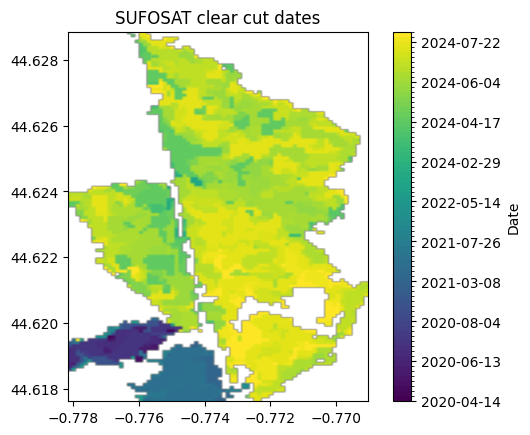

In [7]:
long, lat = -0.77319, 44.62325
size = 0.006
minx, maxx, miny, maxy = (
    -0.7781456631782495,
    -0.7690339007836599,
    44.61761959544384,
    44.62885826228384,
)
plot_raster_dates(
    *load_raster_subset(
        raster_path=INPUT_RASTER_DATES,
        minx=minx,
        maxx=maxx,
        miny=miny,
        maxy=maxy,
    )
)

In [8]:
def polygonize_raster(input_raster: str, output_shapefile: str, fieldname: str):
    """
    Polygonize a raster to a shapefile using 8-connectivity
    """

    # Register GDAL drivers
    gdal.AllRegister()

    # Open source file
    src_ds = gdal.Open(input_raster)
    if src_ds is None:
        raise ValueError(f"Unable to open {input_raster}")

    # Get the first band
    srcband = src_ds.GetRasterBand(1)
    maskband = srcband.GetMaskBand()

    # Create output file
    drv = ogr.GetDriverByName("FlatGeobuf")
    dst_ds = drv.CreateDataSource(output_shapefile)

    # Create layer
    srs = None
    if src_ds.GetProjectionRef() != "":
        srs = osr.SpatialReference()
        srs.ImportFromWkt(src_ds.GetProjectionRef())

    dst_layer = dst_ds.CreateLayer("out", geom_type=ogr.wkbPolygon, srs=srs)

    # Add field
    fd = ogr.FieldDefn(fieldname, ogr.OFTInteger)
    dst_layer.CreateField(fd)

    # Polygonize with 8-connectivity
    options = ["8CONNECTED=8"]
    gdal.Polygonize(srcband, maskband, dst_layer, 0, options)


In [9]:
# This takes 5-10 minutes
polygonize_raster(
    input_raster=INPUT_RASTER_DATES,
    output_shapefile="../data/sufosat/sufosat.fgb",
    fieldname="days",
)

In [10]:
gdf: gpd.GeoDataFrame = gpd.read_file("../data/sufosat/sufosat.fgb")
gdf["date"] = SUFOSAT_START_DATE + pd.to_timedelta(gdf["days"], unit="D") # transformation pour avoir une date

In [11]:
gdf: gpd.GeoDataFrame = gdf[gdf["date"] >= START_DATE_CUTOFF] # on ne prend que les coupes de 2024

In [12]:
gdf

,days,geometry,date
0,3725,"POLYGON ((9.43926 41.1001, 9.43926 41.10001, 9...",2024-06-14
1,3683,"POLYGON ((9.43902 41.1001, 9.43902 41.10001, 9...",2024-05-03
2,3671,"POLYGON ((9.43914 41.1001, 9.43914 41.10001, 9...",2024-04-21
3,3749,"POLYGON ((9.4395 41.10001, 9.4395 41.09992, 9....",2024-07-08
4,3695,"POLYGON ((9.43938 41.09983, 9.43938 41.09964, ...",2024-05-15
...,...,...,...
5920292,3684,"POLYGON ((-1.65395 43.3665, -1.65395 43.36641,...",2024-05-04
5920293,3732,"POLYGON ((-1.65347 43.36632, -1.65347 43.36623...",2024-06-21
5920294,3672,"POLYGON ((-1.65407 43.36641, -1.65407 43.36632...",2024-04-22
5920295,3726,"POLYGON ((-1.65419 43.36632, -1.65419 43.36623...",2024-06-15


<Axes: >

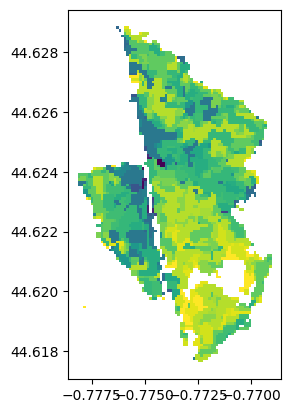

In [13]:
gdf.clip(box(minx, miny, maxx, maxy)).plot(column="days")

### KNN avec les centroïdes

In [30]:
from shapely.ops import unary_union
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Convertir la colonne 'date' en datetime
gdf['date'] = pd.to_datetime(gdf['date'])

# Reprojeter les géométries dans un CRS projeté (Lambert-93, unité = mètre) > mieux pour le calcul des centroïdes
gdf = gdf.to_crs(epsg=2154)

# Calculer les centroïdes des polygones
gdf['centroid'] = gdf.geometry.centroid

# Extraire les coordonnées des centroïdes
centroids = np.array([[point.x, point.y] for point in gdf['centroid']])

# Appliquer l'algorithme KNN
k = 20  # Nombre de voisins les plus proches à considérer
nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(centroids)
distances, indices = nbrs.kneighbors(centroids)

# Regrouper les polygones en fonction des voisins les plus proches et de la condition sur les dates
grouped_polygons = []
grouped_info = []
visited = set()

for i, neighbors in enumerate(indices):
    if i not in visited: # pour chaque indice
        group = set()
        dates = []
        for neighbor in neighbors: # pour chaque voisin
            # si le voisin n'a pas encore été visité et qu'il coche la règle sur le rapprochement temporel...
            if neighbor not in visited and abs((gdf.iloc[i]['date'] - gdf.iloc[neighbor]['date']).days) <= MAX_DAYS_BETWEEN_CLEAR_CUTS:
                group.add(neighbor) #... on ajout le voisin au groupe
                visited.add(neighbor)
                dates.append(gdf.iloc[neighbor]['date']) # ...on récupère la date pour plus tard
        if group: # s'il y a des voisins
            grouped_polygons.append(unary_union(gdf.iloc[list(group)].geometry)) # on les réunit
            grouped_info.append({ # on agrège pour avoir le nb de voisins réunis et la plage temporelle
                'min_date': min(dates),
                'max_date': max(dates),
                'nb_neighbors': len(group)
            })

# Créer un nouveau GeoDataFrame avec les polygones regroupés et les informations supplémentaires
grouped_gdf = gpd.GeoDataFrame({
    'geometry': grouped_polygons,
    'min_date': [info['min_date'] for info in grouped_info],
    'max_date': [info['max_date'] for info in grouped_info],
    'nb_neighbors': [info['nb_neighbors'] for info in grouped_info]
})


# Sauvegarder le résultat dans un nouveau fichier shapefile
# output_shapefile_path = 'chemin/vers/sortie_regroupee.shp'
# grouped_gdf.to_file(output_shapefile_path, driver='ESRI Shapefile')

# print(f"Polygones regroupés sauvegardés dans {output_shapefile_path}")


In [15]:
# 4m pour exécuter l'algo

In [31]:
grouped_gdf

,geometry,min_date,max_date,nb_neighbors
0,"MULTIPOLYGON (((1242171.94 6021758.209, 124217...",2024-05-21,2024-07-08,9
1,"MULTIPOLYGON (((1242189.617 6021790.054, 12421...",2024-04-09,2024-05-15,4
2,"MULTIPOLYGON (((1233293.814 6028394.192, 12332...",2024-03-16,2024-04-15,12
3,"MULTIPOLYGON (((1233232.63 6028399.4, 1233222....",2024-05-15,2024-06-08,6
4,"MULTIPOLYGON (((1233142.879 6028382.048, 12331...",2024-03-16,2024-04-21,5
...,...,...,...,...
79615,"MULTIPOLYGON (((341120.002 6286714.192, 341119...",2024-03-17,2024-04-10,6
79616,"POLYGON ((341004.56 6286559.27, 341005.127 628...",2024-06-15,2024-06-27,2
79617,"MULTIPOLYGON (((341098.961 6286685.11, 341098....",2024-04-16,2024-05-04,3
79618,"MULTIPOLYGON (((341861.344 6287994.132, 341861...",2024-04-04,2024-05-10,9


In [32]:
grouped_gdf.set_crs(epsg=2154, inplace=True)

,geometry,min_date,max_date,nb_neighbors
0,"MULTIPOLYGON (((1242171.94 6021758.209, 124217...",2024-05-21,2024-07-08,9
1,"MULTIPOLYGON (((1242189.617 6021790.054, 12421...",2024-04-09,2024-05-15,4
2,"MULTIPOLYGON (((1233293.814 6028394.192, 12332...",2024-03-16,2024-04-15,12
3,"MULTIPOLYGON (((1233232.63 6028399.4, 1233222....",2024-05-15,2024-06-08,6
4,"MULTIPOLYGON (((1233142.879 6028382.048, 12331...",2024-03-16,2024-04-21,5
...,...,...,...,...
79615,"MULTIPOLYGON (((341120.002 6286714.192, 341119...",2024-03-17,2024-04-10,6
79616,"POLYGON ((341004.56 6286559.27, 341005.127 628...",2024-06-15,2024-06-27,2
79617,"MULTIPOLYGON (((341098.961 6286685.11, 341098....",2024-04-16,2024-05-04,3
79618,"MULTIPOLYGON (((341861.344 6287994.132, 341861...",2024-04-04,2024-05-10,9


In [33]:
grouped_gdf['nb_neighbors'].max()

20

In [34]:
grouped_gdf['nb_neighbors'].min()

1

(array([26400., 18145., 12618.,  8468.,  5560.,  3619.,  2192.,  1336.,
          799.,   483.]),
 array([ 1. ,  2.9,  4.8,  6.7,  8.6, 10.5, 12.4, 14.3, 16.2, 18.1, 20. ]),
 <BarContainer object of 10 artists>)

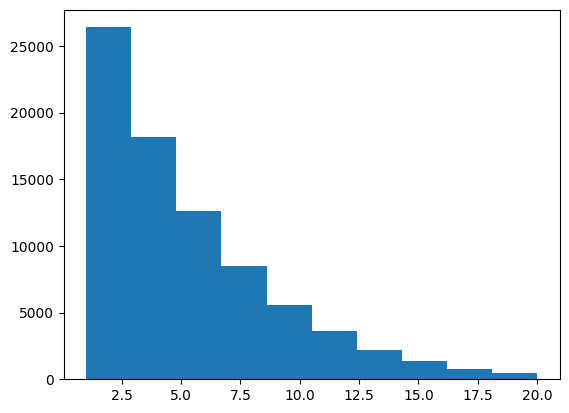

In [19]:
plt.hist(grouped_gdf['nb_neighbors'])

                                                geometry   min_date  \
38065  MULTIPOLYGON (((299086.239 6841727.618, 299086... 2024-06-25   

        max_date  nb_neighbors  
38065 2024-07-22            10  
ID = 38065
https://browser.dataspace.copernicus.eu/?zoom=17&lat=48.55209&lng=-2.43573
https://www.google.com/maps?q=48.55209,-2.43573
0.90 hectares clear cut


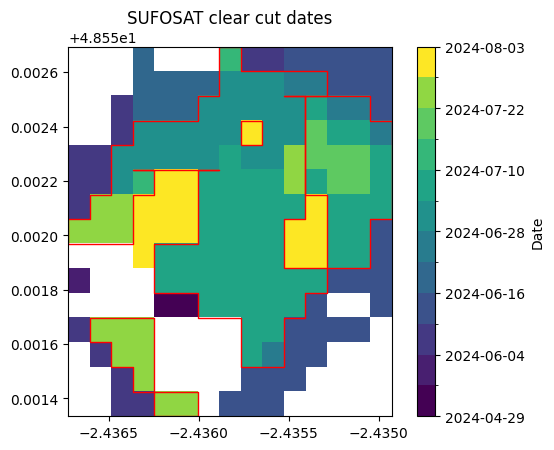

In [35]:
plot_example(grouped_gdf, -2.43573, 48.55209)

                                                geometry   min_date  \
65304  MULTIPOLYGON (((400752.255 6398612.659, 400742... 2024-07-02   

        max_date  nb_neighbors  
65304 2024-07-14             5  
ID = 65304
https://browser.dataspace.copernicus.eu/?zoom=17&lat=44.62325&lng=-0.77319
https://www.google.com/maps?q=44.62325,-0.77319
2.29 hectares clear cut


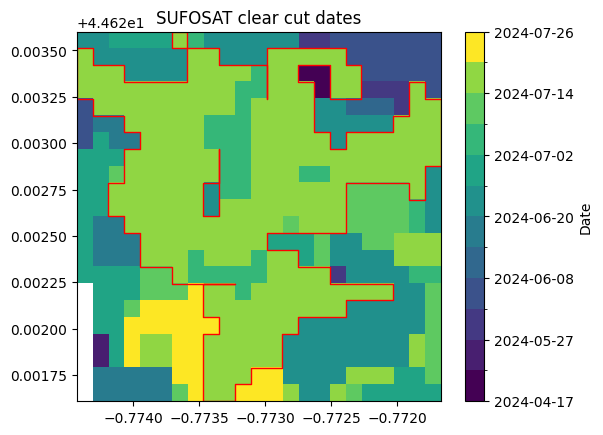

In [36]:
plot_example(grouped_gdf, -0.77319, 44.62325)

#### KNN avec les bords des polygones

In [37]:
# Convertir la colonne 'date' en datetime
gdf['date'] = pd.to_datetime(gdf['date'])

# Reprojeter les géométries dans un CRS projeté (Lambert-93, unité = mètre) > mieux pour le calcul des centroïdes
gdf = gdf.to_crs(epsg=2154)

# Extraire les points des bords des polygones
border_points = []
for geom in gdf.geometry:
    border_points.extend(list(geom.exterior.coords))

# Convertir les points des bords en un tableau numpy
border_points = np.array(border_points)

# Appliquer l'algorithme KNN
k = 20  # Nombre de voisins les plus proches à considérer
nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(border_points)
distances, indices = nbrs.kneighbors(border_points)

# Regrouper les polygones en fonction des voisins les plus proches et de la condition sur les dates
grouped_polygons = []
grouped_info = []
visited = set()

for i, neighbors in enumerate(indices):
    if i not in visited:
        group = set()
        dates = []
        for neighbor in neighbors:
            if neighbor not in visited:
                # Trouver le polygone correspondant au point du bord
                for idx, geom in enumerate(gdf.geometry):
                    if geom.exterior.coords.contains(border_points[neighbor]):
                        if abs((gdf.iloc[i]['date'] - gdf.iloc[idx]['date']).days) <= 30:
                            group.add(idx)
                            visited.add(neighbor)
                            dates.append(gdf.iloc[idx]['date'])
                        break
        if group:
            grouped_polygons.append(unary_union(gdf.iloc[list(group)].geometry))
            grouped_info.append({
                'min_date': min(dates),
                'max_date': max(dates),
                'nb_neighbors': len(group)
            })

# Créer un nouveau GeoDataFrame avec les polygones regroupés et les informations supplémentaires
grouped_gdf = gpd.GeoDataFrame({
    'geometry': grouped_polygons,
    'min_date': [info['min_date'] for info in grouped_info],
    'max_date': [info['max_date'] for info in grouped_info],
    'nb_neighbors': [info['nb_neighbors'] for info in grouped_info]
})

# Reprojeter les polygones regroupés dans le CRS d'origine (par exemple, WGS84)
grouped_gdf.set_crs(epsg=2154, inplace=True)
# grouped_gdf = grouped_gdf.to_crs(epsg=4326)

# # Sauvegarder le résultat dans un nouveau fichier shapefile
# output_shapefile_path = 'chemin/vers/sortie_regroupee.shp'
# grouped_gdf.to_file(output_shapefile_path, driver='ESRI Shapefile')

# print(f"Polygones regroupés sauvegardés dans {output_shapefile_path}")


AttributeError: 'CoordinateSequence' object has no attribute 'contains'

In [ ]:
grouped_gdf

In [ ]:
grouped_gdf['nb_neighbors'].max()

20

In [ ]:
grouped_gdf['nb_neighbors'].min()

1

In [ ]:
plt.hist(grouped_gdf['nb_neighbors'])

In [ ]:
grouped_gdf["days_delta"] = (grouped_gdf["max_date"] - grouped_gdf["min_date"]).dt.days

In [ ]:
plot_example(grouped_gdf, -2.43573, 48.55209)

### Calcul des volumétries après KNN sur les centroïdes

In [ ]:
# 1 hectare = 10,000 m²
grouped_gdf["area_ha"] = grouped_gdf.area / 10000

In [ ]:
grouped_gdf

,geometry,min_date,max_date,nb_neighbors,area_ha,days_delta
0,"MULTIPOLYGON (((32925.862 4564713.61, 32926.50...",2024-05-15,2024-07-08,10,0.397185,54
1,"MULTIPOLYGON (((32920.298 4564784.73, 32920.94...",2024-04-09,2024-05-03,3,0.112018,24
2,"MULTIPOLYGON (((25111.078 4572558.472, 25111.7...",2024-03-04,2024-04-15,13,0.864959,42
3,"MULTIPOLYGON (((25131.863 4572567.227, 25121.7...",2024-05-15,2024-06-08,6,0.101761,24
4,"MULTIPOLYGON (((24960.111 4572568.322, 24939.9...",2024-03-16,2024-04-21,5,0.508803,36
...,...,...,...,...,...,...
77468,"POLYGON ((-828261.695 4959460.573, -828281.076...",2024-03-17,2024-04-16,8,0.396673,30
77469,"POLYGON ((-828365.889 4959345.333, -828363.837...",2024-06-15,2024-06-27,2,0.101715,12
77470,"POLYGON ((-828260.561 4959565.302, -828264.664...",2024-05-04,2024-05-04,1,0.020342,0
77471,"MULTIPOLYGON (((-827289.212 4960669.096, -8272...",2024-04-04,2024-05-10,9,0.203370,36


In [ ]:
grouped_gdf[grouped_gdf["area_ha"] >= 0.5].count()

,0
geometry,15166
min_date,15166
max_date,15166
nb_neighbors,15166
area_ha,15166


In [ ]:
grouped_gdf[grouped_gdf["area_ha"] >= 10].count()

,0
geometry,16
min_date,16
max_date,16
nb_neighbors,16
area_ha,16
